In [76]:
import umap 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn
import torch 
import torch_geometric as pyg 
import sklearn 
from gsnn.models.GSNN import GSNN
import sys 
import argparse 
from torch.profiler import profile, record_function, ProfilerActivity
from gsnn_lib.data.LincsDataset import LincsDataset
import os 
from torch.utils.data import DataLoader
import scipy
from gsnn_lib.proc.prism.utils import load_prism
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
test_ixs = torch.load('../../output/sciplex3/test_idxs.pt', weights_only=False)
test_ixs[:10]

tensor([141974, 162996, 119264, 333856, 261918, 320199, 198319, 133951, 316404,
        234682])

In [77]:
y_fnames = [x for x in os.listdir('../../output/sciplex3/PROC/') if x[:4] == 'pert']

y = [] 
for i,fname in enumerate(y_fnames[0:10000]):
    print(f'loading data...{i}/{len(y_fnames)}', end='\r')
    y.append(torch.load(f'../../output/sciplex3/PROC/{fname}', weights_only=True).view(1,-1))
y = torch.cat(y, dim=0)
y.size()

torch.Size([10000, 748])

In [78]:
reducer = PCA(n_components=2)
y_reduced = reducer.fit_transform(y.cpu().numpy())

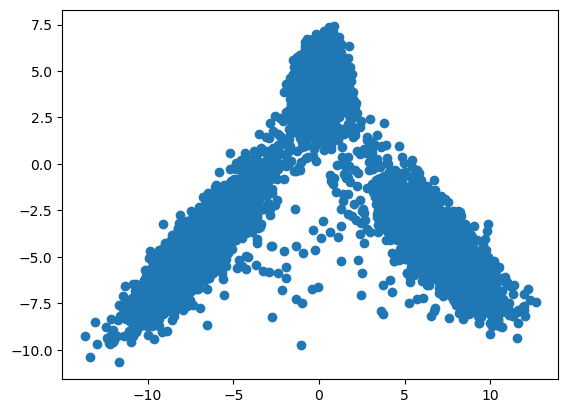

In [79]:
plt.figure() 
plt.scatter(y_reduced[:,0], y_reduced[:,1])
plt.show()

In [51]:
test_cell_gsnn = pd.read_csv('/home/teddy/local/gsnn-lib/output/GSNN/9d01f9ff-f298-4efa-8361-6c39bd017764/test_cell_metrics.csv')
test_drug_gsnn = pd.read_csv('/home/teddy/local/gsnn-lib/output/GSNN/9d01f9ff-f298-4efa-8361-6c39bd017764/test_drug_metrics.csv')
test_gene_gsnn = pd.read_csv('/home/teddy/local/gsnn-lib/output/GSNN/9d01f9ff-f298-4efa-8361-6c39bd017764/test_gene_metrics.csv')

test_cell_nn = pd.read_csv('/home/teddy/local/gsnn-lib/output/NN/1ecf582d-a6de-41d1-a4ea-c7cb0f87653e/test_cell_metrics.csv')
test_drug_nn = pd.read_csv('/home/teddy/local/gsnn-lib/output/NN/1ecf582d-a6de-41d1-a4ea-c7cb0f87653e/test_drug_metrics.csv')
test_gene_nn = pd.read_csv('/home/teddy/local/gsnn-lib/output/NN/1ecf582d-a6de-41d1-a4ea-c7cb0f87653e/test_gene_metrics.csv')

In [55]:
drug_df = test_drug_gsnn.merge(test_drug_nn, on='pert_id', suffixes=('_gsnn', '_nn'))
cell_df = test_cell_gsnn.merge(test_cell_nn, on='cell_iname', suffixes=('_gsnn', '_nn'))
gene_df = test_gene_gsnn.merge(test_gene_nn, on='gene', suffixes=('_gsnn', '_nn'))

In [65]:
gene_df.set_index('gene').loc['P04637']

r2_gsnn           0.079641
mse_gsnn          2.096609
pearsonr_gsnn     0.287494
spearmanr_gsnn    0.181472
r2_nn             0.054432
mse_nn            2.154035
pearsonr_nn       0.237790
spearmanr_nn      0.186867
Name: P04637, dtype: float64

In [57]:
print('nn spearman', test_gene_nn.spearmanr.mean())
print('gsnn spearman', test_gene_gsnn.spearmanr.mean())

nn 0.21994850155285434
gsnn 0.1765563545241229


In [58]:
print('nn pearson', test_gene_nn.pearsonr.mean())
print('gsnn pearson', test_gene_gsnn.pearsonr.mean())

nn pearson 0.3495320968951823
gsnn pearson 0.35065872652846847


In [59]:
print('nn r2', test_gene_nn.r2.mean())
print('gsnn r2', test_gene_gsnn.r2.mean())

nn r2 0.13295216438097826
gsnn r2 0.13133975318354416


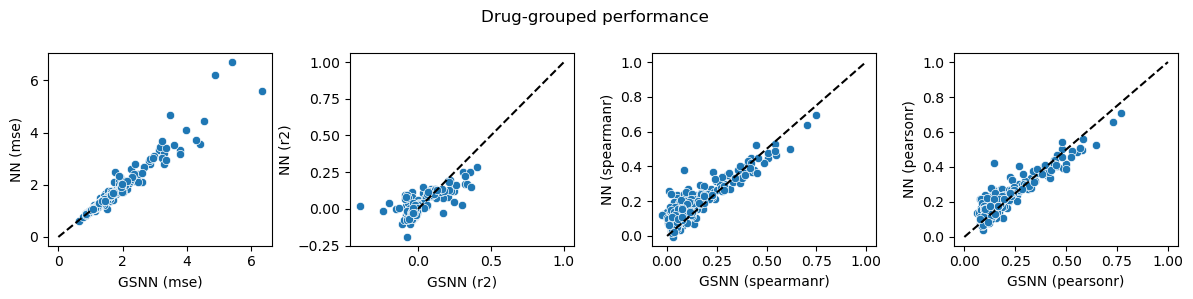

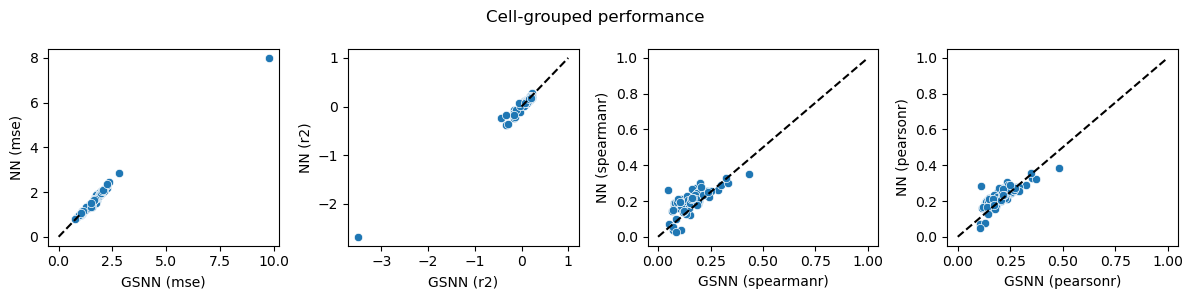

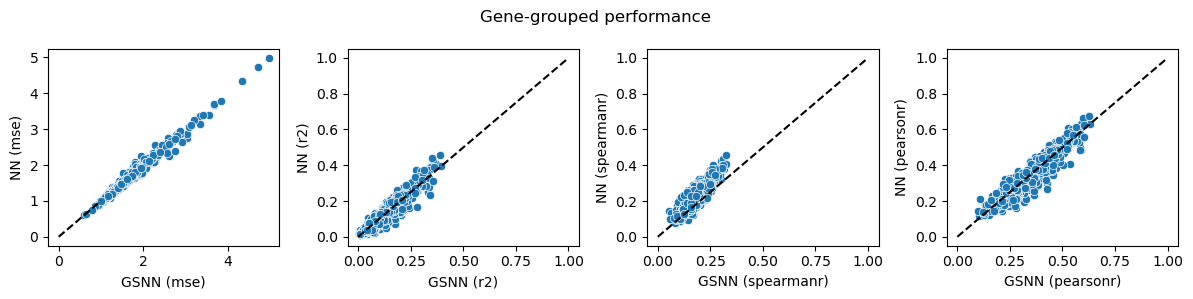

In [56]:
f, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, metric in zip(axes, ['mse', 'r2', 'spearmanr', 'pearsonr']):
    sbn.scatterplot(data=drug_df, x=f'{metric}_gsnn', y=f'{metric}_nn', ax=ax)
    ax.plot((0,1), (0,1), 'k--')
    ax.set_xlabel(f'GSNN ({metric})')
    ax.set_ylabel(f'NN ({metric})')

plt.suptitle('Drug-grouped performance')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, metric in zip(axes, ['mse', 'r2', 'spearmanr', 'pearsonr']):
    sbn.scatterplot(data=cell_df, x=f'{metric}_gsnn', y=f'{metric}_nn', ax=ax)
    ax.plot((0,1), (0,1), 'k--')
    ax.set_xlabel(f'GSNN ({metric})')
    ax.set_ylabel(f'NN ({metric})')

plt.suptitle('Cell-grouped performance')
plt.tight_layout()
plt.show()


f, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, metric in zip(axes, ['mse', 'r2', 'spearmanr', 'pearsonr']):
    sbn.scatterplot(data=gene_df, x=f'{metric}_gsnn', y=f'{metric}_nn', ax=ax)
    ax.plot((0,1), (0,1), 'k--')
    ax.set_xlabel(f'GSNN ({metric})')
    ax.set_ylabel(f'NN ({metric})')

plt.suptitle('Gene-grouped performance')
plt.tight_layout()
plt.show()

NameError: name 'test_gsnn_drug' is not defined

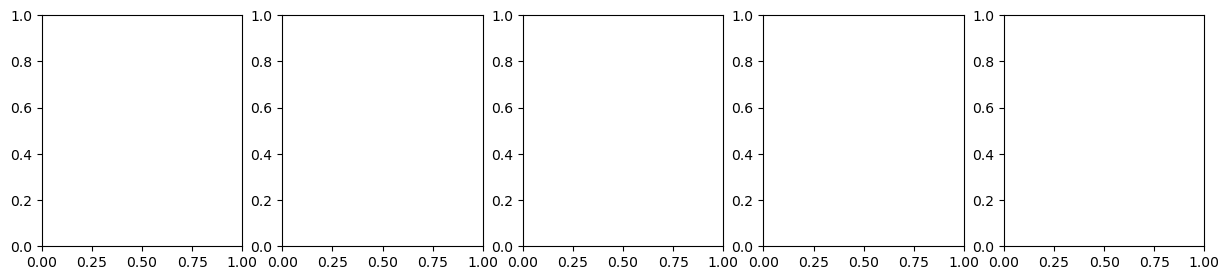

In [60]:
f, axes = plt.subplots(1, 5, figsize=(15,3))
sbn.histplot(test_gsnn_drug.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(test_gsnn_drug.mse.values, ax=axes[1], bins=25)
sbn.histplot(test_gsnn_drug.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(test_gsnn_drug.spearmanr.values, ax=axes[3], bins=25)
sbn.histplot(test_gsnn_drug.N.values, ax=axes[4], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')
axes[4].set_title('N')

for ax in axes:
    ax.set_yscale('log')
    
plt.suptitle('Drug-grouped metrics')
plt.tight_layout()
plt.show()

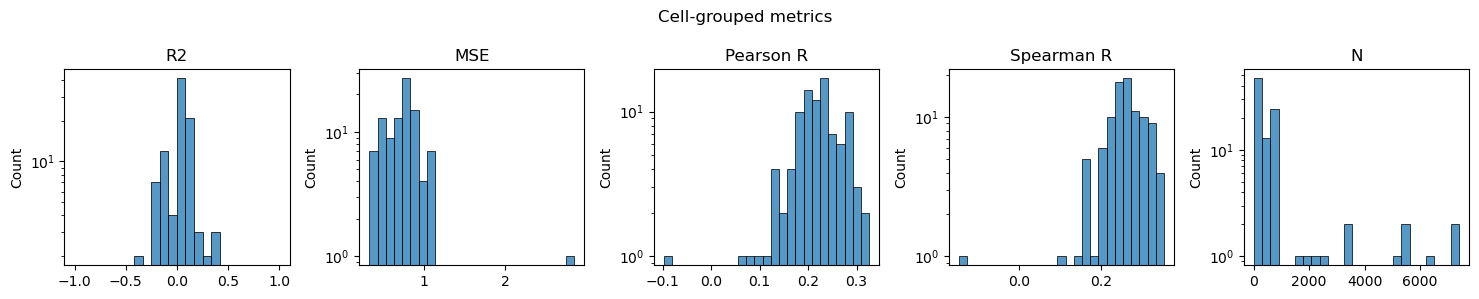

In [30]:
f, axes = plt.subplots(1, 5, figsize=(15,3))
sbn.histplot(test_cell.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(test_cell.mse.values, ax=axes[1], bins=25)
sbn.histplot(test_cell.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(test_cell.spearmanr.values, ax=axes[3], bins=25)
sbn.histplot(test_cell.N.values, ax=axes[4], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')
axes[4].set_title('N')

for ax in axes:
    ax.set_yscale('log')
    
plt.suptitle('Cell-grouped metrics')
plt.tight_layout()
plt.show()

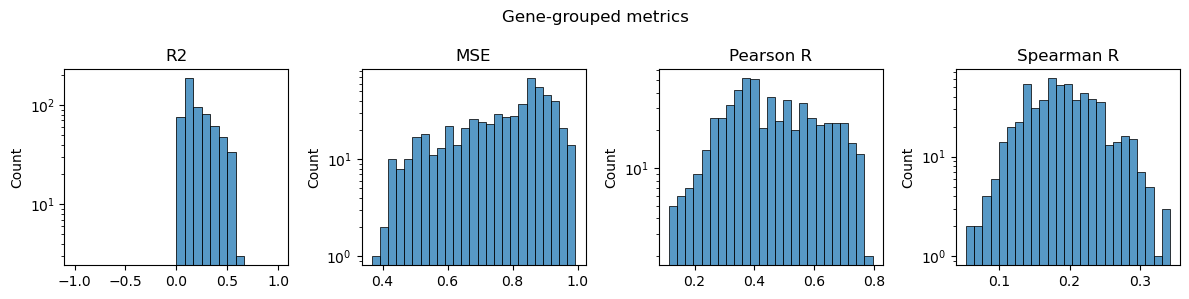

In [31]:
f, axes = plt.subplots(1, 4, figsize=(12,3))
sbn.histplot(test_gene.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(test_gene.mse.values, ax=axes[1], bins=25)
sbn.histplot(test_gene.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(test_gene.spearmanr.values, ax=axes[3], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')

for ax in axes:
    ax.set_yscale('log')
    
plt.suptitle('Gene-grouped metrics')
plt.tight_layout()
plt.show()

In [6]:
def agg_fold_metrics(path):

    folds = np.sort([x for x in os.listdir(path) if os.path.isdir(os.path.join(path, x))])
    metrics = []
    for fold in folds:
        fold_path = os.path.join(path, fold)
        metrics.append(torch.load(os.path.join(fold_path, 'result_metric_dict.pt'), weights_only=False))

    avg_metrics = {} 
    for key in metrics[0].keys():
        avg_metrics[key] = np.mean([x[key] for x in metrics])

    return avg_metrics

In [2]:
def agg_fold_val_metrics(path):

    folds = np.sort([x for x in os.listdir(path) if os.path.isdir(os.path.join(path, x))])
    

def agg_fold_predictions(path): 
    '''
    Aggregate test predictions from all folds in a given path (uid)
    '''

    folds = np.sort([x for x in os.listdir(path) if os.path.isdir(os.path.join(path, x))])
    
    preds = [] 
    sig_ids = []
    for fold in folds:
        preds.append( torch.load(path + '/' + fold + '/test_predictions.pt', weights_only=False))
        sig_ids.append( np.concatenate(torch.load(path + '/' + fold + '/test_sig_ids.pt', weights_only=False)) ) 

    sig_ids = np.concatenate(sig_ids, 0)
    preds = np.concatenate(preds, 0)

    return preds, sig_ids

def load_y(proc, sig_ids): 
    ''' 
    Load y from processed data
    '''

    y = [] 
    for i,sig_id in enumerate(sig_ids): 
        print('progress: ', i, ' / ', len(sig_ids), end='\r')
        y.append( torch.load(proc + '/obs/' + sig_id + '.pt', weights_only=True) ) 

    y = torch.stack(y, 0)
    y = y.detach().cpu().numpy()
    return y 

def grouped_eval(y, preds, sig_ids, data, siginfo):

    siginfo = siginfo[lambda x: x.sig_id.isin(sig_ids)]  
    sig2idx = {x:i for i,x in enumerate(sig_ids)}

    drug_metrics = {'pert_id': [], 'r2': [], 'mse': [], 'pearsonr': [], 'spearmanr':[], 'N':[]}
    for i,row in siginfo[['pert_id', 'sig_id']].groupby('pert_id').agg(lambda x: list(x)).reset_index().iterrows(): 
        print('calculating drug-grouped metrics... ', i, ' / ', len(siginfo.pert_id.unique()), end='\r')
        didxs = [sig2idx[x] for x in row.sig_id]
        yy = y[didxs]
        yyhat = preds[didxs] 

        drug_metrics['pert_id'].append(row.pert_id)
        drug_metrics['r2'].append(sklearn.metrics.r2_score(yy, yyhat, multioutput='variance_weighted'))
        drug_metrics['mse'].append( np.mean((yy - yyhat)**2) )  
        drug_metrics['pearsonr'].append( np.mean([np.corrcoef(yy[i], yyhat[i])[0,1] for i in range(yy.shape[0])]) )
        drug_metrics['spearmanr'].append( np.mean([scipy.stats.spearmanr(yy[i], yyhat[i]).statistic for i in range(yy.shape[0])]) )
        drug_metrics['N'].append(yy.shape[0])

    drug_metrics = pd.DataFrame(drug_metrics)
    print()

    ### performance by cell line 
    cell_metrics = {'cell_iname': [], 'r2': [], 'mse': [], 'pearsonr': [], 'spearmanr':[], 'N':[]}
    for i,row in siginfo[['cell_iname', 'sig_id']].groupby('cell_iname').agg(lambda x: list(x)).reset_index().iterrows(): 
        print('calculating cell-grouped metrics... ', i, ' / ', len(siginfo.cell_iname.unique()), end='\r')
        didxs = [sig2idx[x] for x in row.sig_id]
        yy = y[didxs]
        yyhat = preds[didxs] 

        cell_metrics['cell_iname'].append(row.cell_iname)
        cell_metrics['r2'].append(sklearn.metrics.r2_score(yy, yyhat, multioutput='variance_weighted'))
        cell_metrics['mse'].append( np.mean((yy - yyhat)**2) )  
        cell_metrics['pearsonr'].append( np.mean([np.corrcoef(yy[i], yyhat[i])[0,1] for i in range(yy.shape[0])]) )
        cell_metrics['spearmanr'].append( np.mean([scipy.stats.spearmanr(yy[i], yyhat[i]).statistic for i in range(yy.shape[0])]) )
        cell_metrics['N'].append(yy.shape[0])

    cell_metrics = pd.DataFrame(cell_metrics)
    print()

    ### performance by genes
    lincspace = data['node_names_dict']['output']
    gene_metrics = {'gene': [], 'r2': [], 'mse': [], 'pearsonr': [], 'spearmanr': []}
    for i in range(y.shape[1]): 
        print('calculating gene-grouped metrics... ', i, ' / ', y.shape[1], end='\r')

        yy = y[:,i]
        yyhat = preds[:,i]
        gene = lincspace[i].split('_')[1]

        gene_metrics['gene'].append(gene)
        gene_metrics['r2'].append(sklearn.metrics.r2_score(yy, yyhat))
        gene_metrics['mse'].append(np.mean((yy - yyhat)**2))
        gene_metrics['pearsonr'].append(np.corrcoef(yy, yyhat)[0,1])
        gene_metrics['spearmanr'].append(scipy.stats.spearmanr(yy, yyhat).statistic)
            
    gene_metrics = pd.DataFrame(gene_metrics)
    print() 

    return drug_metrics, cell_metrics, gene_metrics


In [3]:
path = '/home/teddy/local/gsnn-lib/output/5dfaa74e-6691-435a-992d-2a87ca2756d0'
proc = '../../proc/lincs/'

siginfo = pd.read_csv('../../../data/siginfo_beta.txt', sep='\t', low_memory=False)
data = torch.load(proc + '/data.pt', weights_only=False)

avg_metrics = agg_fold_metrics(path)
preds, sig_ids = agg_fold_predictions(path)
y = load_y(proc, sig_ids)
drug_metrics, cell_metrics, gene_metrics = grouped_eval(y, preds, sig_ids, data, siginfo)

/tmp/ipykernel_13247/488584742.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sig_ids.append( np.concatenate(torch.load(path + '/' + fold + '/test_sig_ids.pt' )) )


In [15]:
drug_metrics.r2.max()

0.037919122725725174

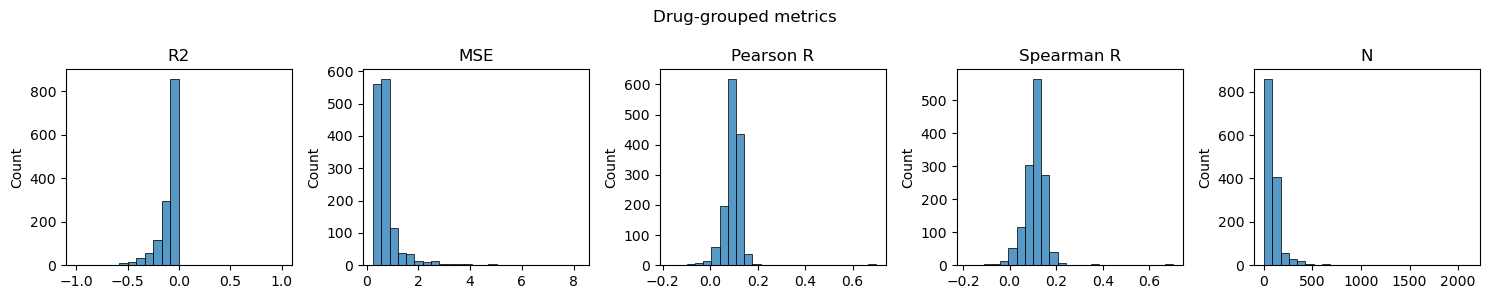

In [5]:
f, axes = plt.subplots(1, 5, figsize=(15,3))
sbn.histplot(drug_metrics.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(drug_metrics.mse.values, ax=axes[1], bins=25)
sbn.histplot(drug_metrics.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(drug_metrics.spearmanr.values, ax=axes[3], bins=25)
sbn.histplot(drug_metrics.N.values, ax=axes[4], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')
axes[4].set_title('N')
plt.suptitle('Drug-grouped metrics')
plt.tight_layout()
plt.show()

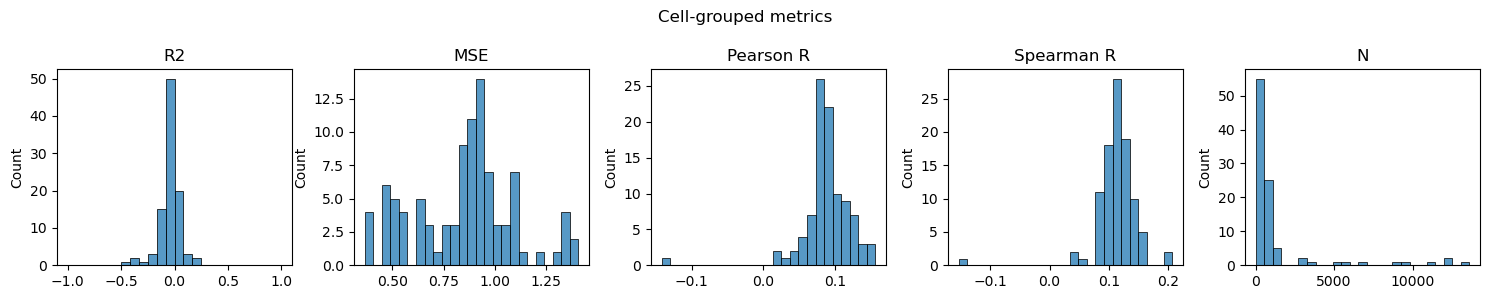

In [4]:
f, axes = plt.subplots(1, 5, figsize=(15,3))
sbn.histplot(cell_metrics.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(cell_metrics.mse.values, ax=axes[1], bins=25)
sbn.histplot(cell_metrics.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(cell_metrics.spearmanr.values, ax=axes[3], bins=25)
sbn.histplot(cell_metrics.N.values, ax=axes[4], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')
axes[4].set_title('N')
plt.suptitle('Cell-grouped metrics')
plt.tight_layout()
plt.show()

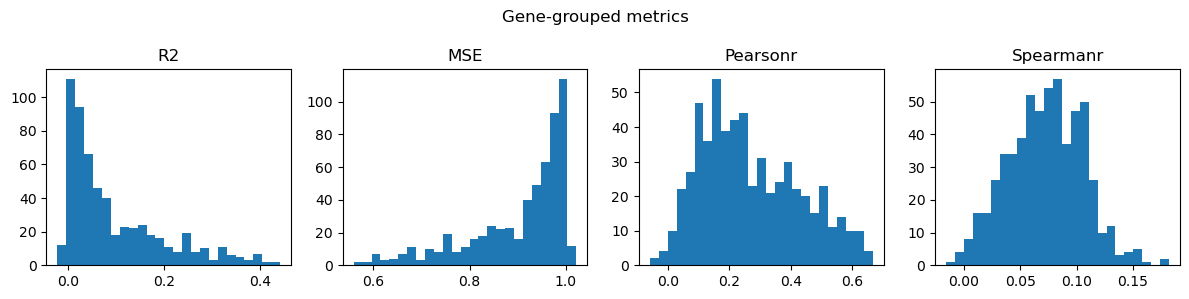

In [17]:
f, axes = plt.subplots(1, 4, figsize=(12,3))
axes[0].hist(gene_metrics.r2.values, bins=25)
axes[1].hist(gene_metrics.mse.values, bins=25)
axes[2].hist(gene_metrics.pearsonr.values, bins=25)
axes[3].hist(gene_metrics.spearmanr.values, bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearsonr')
axes[3].set_title('Spearmanr')

plt.suptitle('Gene-grouped metrics')
plt.tight_layout()
plt.show()

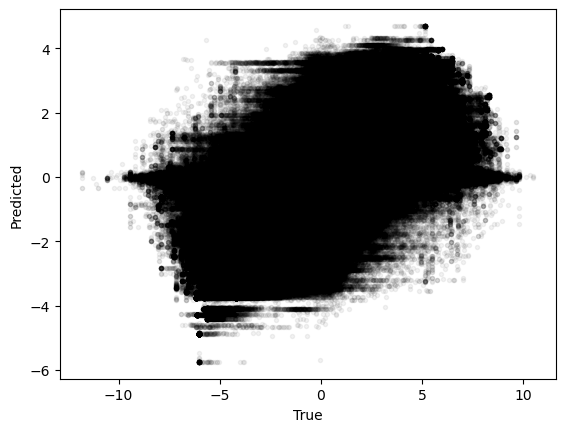

In [18]:
plt.figure() 
plt.plot(y.ravel(), preds.ravel(), 'k.' ,alpha=0.01)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show() 

In [13]:
siginfo = pd.read_csv(f'../../../data/siginfo_beta.txt', sep='\t', low_memory=False)

In [15]:
siginfo.pert_type.unique()

array(['trt_cp', 'trt_oe', 'trt_sh', 'trt_si', 'trt_aby', 'trt_lig',
       'trt_xpr', 'ctl_vector', 'ctl_vehicle', 'ctl_untrt',
       'ctl_vector.cns', 'ctl_vehicle.cns', 'ctl_untrt.cns', 'ctl_x',
       'trt_sh.cgs', 'trt_sh.css'], dtype=object)

In [18]:
' '.join(siginfo[lambda x: x.pert_type == 'trt_cp'].groupby('pert_id').count()[['bead_batch']].sort_values('bead_batch', ascending=False).reset_index().head(10).pert_id.values)

'BRD-K60230970 BRD-K50691590 BRD-K81418486 BRD-K49865102 BRD-K21680192 BRD-K88510285 BRD-A79768653 BRD-A75409952 BRD-K49328571 BRD-A19037878'

In [12]:
train_ids = np.load(f'../../data/all/lincs_train_obs.npy', allow_pickle=True)
train_dataset = LincsDataset(root=f'../../data/all', sig_ids=train_ids, data=data, siginfo=siginfo)

In [14]:
x, y, sig_id = train_dataset.__getitem__(0)

In [17]:
with torch.no_grad(): 
    yhat = model(x.cuda())

RuntimeError: The size of tensor a (5515715790) must match the size of tensor b (21702600) at non-singleton dimension 0

In [2]:

data = torch.load('../../data/all/data.pt')
model = GSNN(data.edge_index_dict, 
             data.node_names_dict, 
             channels=5, 
             layers=5)

x = torch.randn((10, len(data.node_names_dict['input'])))


with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model(x)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

INFO:2024-09-13 21:05:33 17909:17909 init.cpp:158] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti
STAGE:2024-09-13 21:05:33 17909:17909 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           aten::scatter_add_        42.22%     224.121ms        42.22%     224.121ms       8.965ms           0 b           0 b            25  
                    aten::mul        14.09%      74.804ms        14.09%      74.804ms       3.937ms     327.32 Mb     327.32 Mb            19  
           aten::index_select        14.03%      74.470ms        14.06%      74.623ms       3.731ms     194.68 Mb     194.68 Mb            20  
                  aten::copy_        11.52%      61.136ms        11.52%      61.136ms       1.747ms           0 b           0 b         

STAGE:2024-09-13 21:05:34 17909:17909 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-13 21:05:34 17909:17909 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [8]:
data = torch.load('../../data/all/data.pt')
model = GSNN(data.edge_index_dict, 
             data.node_names_dict, 
             channels=5, 
             layers=5).cuda()

x = torch.randn((10, len(data.node_names_dict['input']))).cuda()

with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(x)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
              model_inference        17.02%       5.138ms       100.00%      30.184ms      30.184ms             1  
                  aten::zeros         0.07%      20.000us         0.36%     108.000us      54.000us             2  
                  aten::empty         1.15%     346.000us         1.15%     346.000us       3.531us            98  
                  aten::zero_         0.38%     114.000us         2.20%     663.000us      24.556us            27  
                  aten::fill_         2.29%     691.000us         2.29%     691.000us      20.939us            33  
                  aten::slice         0.27%      82.000us         0.29% 

STAGE:2024-09-13 21:07:50 17909:17909 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-09-13 21:07:50 17909:17909 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-13 21:07:50 17909:17909 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [7]:
print(prof.key_averages().table())

In [16]:
args = argparse.Namespace()
args.data ='../../../data/'
data = torch.load('../../data/all/data.pt')
drugspace = [x.split('__')[1] for x in data.node_names_dict['input'] if 'DRUG__' in x]
prism = load_prism(args.data, cellspace=data.cellspace, drugspace=drugspace)

/home/teddy/local/GSNN/gsnn/proc/utils.py:163: FutureWarning: The provided callable <function mean at 0x7f100ad080e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  prism = prism.groupby(['pert_id', 'depmap_id', 'cell_iname', 'pert_dose']).agg({'log_fold_change':np.mean, 'screen_id':list}).reset_index()


In [17]:
prism.head()

,pert_id,depmap_id,cell_iname,pert_dose,log_fold_change,screen_id,num_repl,sig_id,cell_viab
0,BRD-A00147595,ACH-000012,HCC827,2.5,0.088670,[primary],1,HCC827::BRD-A00147595::2.5,1.063389
1,BRD-A00147595,ACH-000019,MCF7,2.5,0.018010,[primary],1,MCF7::BRD-A00147595::2.5,1.012562
2,BRD-A00147595,ACH-000048,TOV112D,2.5,0.461293,[primary],1,TOV112D::BRD-A00147595::2.5,1.376775
3,BRD-A00147595,ACH-000052,A673,2.5,0.518615,[primary],1,A673::BRD-A00147595::2.5,1.432579
4,BRD-A00147595,ACH-000087,SKES1,2.5,0.781814,[primary],1,SKES1::BRD-A00147595::2.5,1.719291


In [ ]:
prism.assign()

In [4]:
siginfo = pd.read_csv('../../../data/siginfo_beta.txt', sep='\t', low_memory=False)
siginfo.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0
3,b18,10.0,10.0,uM,10 uM,3 h,3.0,h,HME1,BRD-K81418486,...,HME1,F19,LTC002_HME1_3H_X1_B18,LTC002_HME1_3H_X1_B18:F19,NaN,LTC,vorinostat,0,0.0,0.0
4,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,H1975,BRD-A61304759,...,H1975,P01|P05|P09,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:P01|ABY001_H1975_XH_X1_...,NaN,ABY,tanespimycin,0,0.0,0.0


In [8]:
siginfo[lambda x: x.pert_type == 'trt_cp'].groupby('pert_time').count().sort_values('sig_id', ascending=False)

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time_unit,cell_mfc_name,pert_mfc_id,nsample,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
pert_time,,,,,,,,,,,,,,,,,,,,,
24.0,559163,558320,559107,559163,559107,559163,559163,559163,559163,559163,...,559163,559163,559163,559163,0,559163,559163,559163,559163,559163
6.0,138006,137994,137961,137997,137961,138006,138006,138006,138006,138006,...,138006,138006,138006,138006,0,138006,138006,138006,138006,138006
3.0,11998,11974,11998,11998,11998,11998,11998,11998,11998,11998,...,11998,11998,11998,11998,0,11998,11998,11998,11998,11998
4.0,4704,3492,4704,4704,4704,4704,4704,4704,4704,4704,...,4704,4704,4704,4704,0,4704,4704,4704,4704,4704
48.0,4372,4369,4372,4372,4372,4372,4372,4372,4372,4372,...,4372,4372,4372,4372,0,4372,4372,4372,4372,4372
72.0,796,793,796,796,796,796,796,796,796,796,...,796,796,796,796,0,796,796,796,796,796
12.0,360,357,360,360,360,360,360,360,360,360,...,360,360,360,360,0,360,360,360,360,360
-666.0,230,230,230,230,230,0,230,230,230,230,...,230,230,230,230,0,230,230,230,230,230
2.0,188,188,188,188,188,188,188,188,188,188,...,188,188,188,188,0,188,188,188,188,188


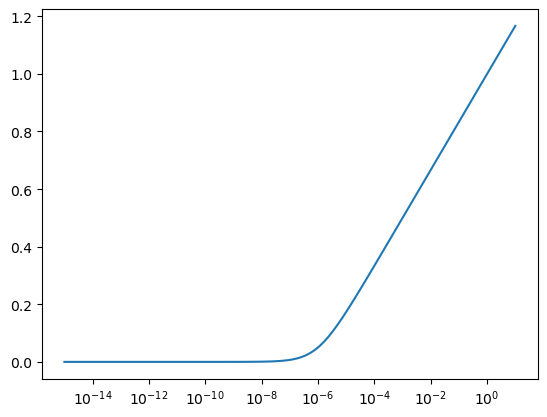

In [10]:
plt.figure() 
x = np.logspace(-15,1, 100)
y = -(np.log10(x + 1e-6) - np.log10(1e-6))/np.log10(1e-6)
plt.plot(x,y)
plt.xscale('log')
plt.show()

In [2]:
mut = load_mut(path='../../../data/', extpath='../../extdata/', include_variants=['damaging'])

In [4]:
mut[['P04637']].head() # TP53 

uniprot,P04637
cell_iname,
22RV1,1.0
5637,0.0
A204,0.0
A375,0.0
A549,0.0


In [5]:
mut[['P04637']].sum()

uniprot
P04637    31.0
dtype: float64

In [9]:
mut[['P01116']].sum()

uniprot
P01116    2.0
dtype: float64